# Forecast Notebook

* Intaractive Forecast Tool Concept
* Accessible as AI LLM/Langchain Tool


Example Forecast Sales Quantity
  * Next N-Month, N-days, N Weeks
  * Aggregate Week, Month (as required)
  * Optionally - specify product list, country, category
  * Filter out (Product List)

Dataset
* Online Sales (UCI) + Product Info (Looker Storytelling)

# Notebook Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import beautifulplots as bp

pd.set_option('display.max_columns', 500)

# ML Prep Transforms
from mlprep import transforms as mlprep_transforms

# Forceast Neural Nets
#from forecast_neural_networks import get_dense_nn, get_dense_emb_nn

# SF Forecast
import sforecast as sf

# endog transforms
#from endogenous_transforms import rolling_transformer


2024-06-18 09:29:44.467437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Processing Parameters

In [2]:
#@@@ Data Prep ###############
# column filters
filter_in = {"Country":["United Kingdom","Netherlands","EIRE"]}
filter_out = {"StockCode":["DOT", "M", "BANK CHARGES", "POST"]}

# series period, aggregate, groupby
frequency = "W"  #  data_prep and mlprep

aggs = {
    "NumOrders": "count",
    "Quantity": "sum",
    "SalesRevenue": "sum"
}
group_by =  [ "Country"]


# datetime filter 
# -- initial data filter prior to mlprep datetime filter
# -- data should all fit within this period
start_data = "2010-12-1"
end_data = "2012-1-1"
datetime_data = "InvoiceDate"

In [3]:
#@@@ ML Prep ###############
#mldata_cols_remove = ["Country", "SalesRevenue"]
mldata_start = "2011-1-1"
mldata_end = "2011-12-1"

# Load Data


Sales w Product Info

In [4]:
data_dir = "../data"
filename = "online_sales_w_prod_info.csv"
path_file = f'{data_dir}/{filename}'
df = pd.read_csv(path_file, dtype=str)
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])
df = df.astype({"Quantity":int, "UnitPrice": float, "SalesRevenue": float, "UnitCost": float, "Profit":float})

df["NumOrders"] = 0 # below ... groupby period,  "count"  below

display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase,SalesRevenue,ProductCode,ProductName,UnitCost,Profit,NumOrders
0,545279,21238,RED RETROSPOT CUP,6,2011-03-01,0.85,17811,United Kingdom,Repeat Customer,5.1,21238,Red retrospot cup,0.43,2.52,0
1,545279,22844,VINTAGE CREAM DOG FOOD CONTAINER,1,2011-03-01,8.50,17811,United Kingdom,Repeat Customer,8.5,22844,Vintage cream dog food container,2.55,5.95,0
2,545279,21731,RED TOADSTOOL LED NIGHT LIGHT,4,2011-03-01,1.65,17811,United Kingdom,Repeat Customer,6.6,21731,Red toadstool led night light,0.83,3.28,0
3,545279,21240,BLUE POLKADOT CUP,12,2011-03-01,0.85,17811,United Kingdom,Repeat Customer,10.2,21240,Blue polkadot cup,0.34,6.12,0
4,545279,22845,VINTAGE CREAM CAT FOOD CONTAINER,12,2011-03-01,5.55,17811,United Kingdom,Repeat Customer,66.6,22845,Vintage cream cat food container,1.67,46.56,0


In [5]:
# sales by country
df.groupby(["Country"])[["Quantity","SalesRevenue"]].sum().reset_index().sort_values("Quantity",ascending=False ).head(10)

,Country,Quantity,SalesRevenue
36,United Kingdom,4244851,8317915.49
24,Netherlands,197742,279389.23
10,EIRE,141408,261651.97
14,Germany,116439,218797.21
13,France,109317,194686.02
0,Australia,82972,135484.84
32,Sweden,35501,36279.91
33,Switzerland,29978,55603.84
20,Japan,25218,35340.62
31,Spain,24257,45805.83


## Worldbank Temperature Data

* https://www.kaggle.com/datasets/noaa/global-historical-climatology-network?resource=download


# Aggregate and Filter for Forecasting

In [6]:
from data_transforms import transforms as data_transforms

dtx = data_transforms(df)

# transforms
dfseries = (dtx.filter(filter_in = filter_in, filter_out=filter_out )
            .frequency(datetime_column=datetime_data, aggs=aggs, frequency=frequency, group_by = group_by)
            .filter_datetime(start_data,end_data) 
            .return_df()
            )

print("dfseries")
display(dfseries.tail())


dfseries


,tp,Country,NumOrders,Quantity,SalesRevenue
138,2011-11-28,Netherlands,3,50,104.00
139,2011-11-28,United Kingdom,17438,133180,274597.61
140,2011-12-05,EIRE,252,2999,5457.99
141,2011-12-05,Netherlands,82,7694,11262.42
142,2011-12-05,United Kingdom,16210,136803,275392.44


# Plot

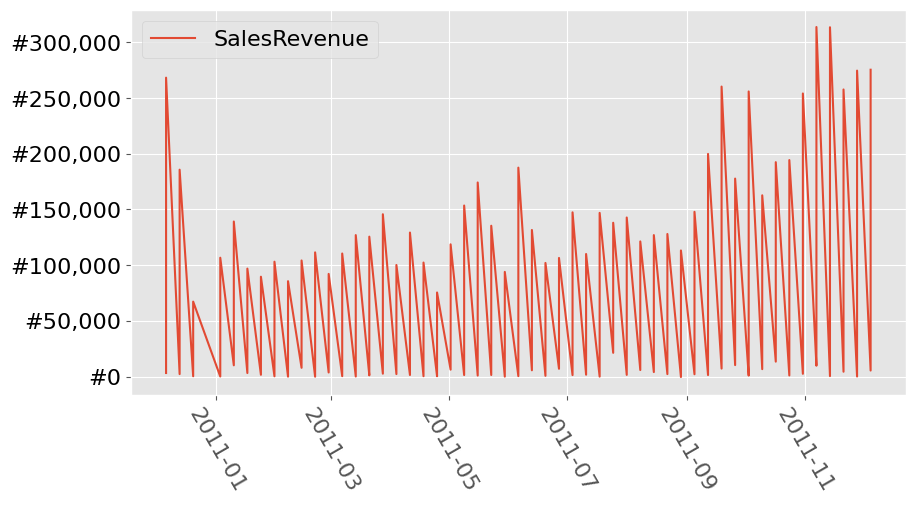

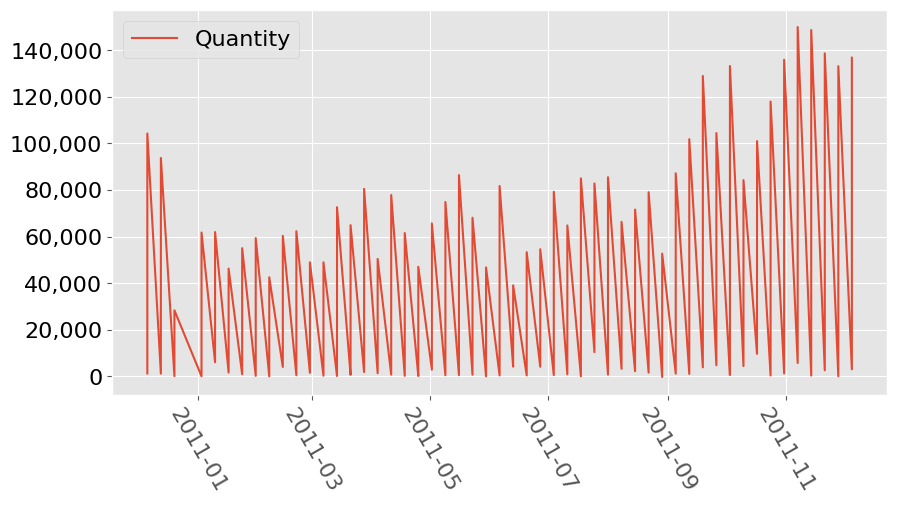

In [7]:

# Sales Revenue
bp.lineplot(dfseries, x="tp", y = "SalesRevenue", pltstyle='ggplot', y_axis_format=",.0f", y_currency="#", x_tick_rotation=-60, figsize=(10,5))

# Sales Quantity
bp.lineplot(dfseries, x="tp", y = "Quantity", y_axis_format=",.0f", pltstyle='ggplot', figsize=(10,5), x_tick_rotation=-60,)


# Forecast

## Univariate

In [9]:
dfseries.head()

,tp,Country,NumOrders,Quantity,SalesRevenue
3,2010-12-06,EIRE,117,1271,3248.55
4,2010-12-06,United Kingdom,15436,104270,268273.59
5,2010-12-13,EIRE,107,1174,2269.08
6,2010-12-13,United Kingdom,10309,93749,185690.15
7,2010-12-20,EIRE,65,101,312.54


In [10]:
dfseries.columns


Index(['tp', 'Country', 'NumOrders', 'Quantity', 'SalesRevenue'], dtype='object')

In [11]:
# Univariate Data
mltx = mlprep_transforms(dfseries, datetime_column="tp", frequency=frequency)

dfxy = ( mltx
         .wide_format("tp", "Country", ["Quantity","SalesRevenue"])
        .filter_datetime(datetime_start=mldata_start, datetime_end=mldata_end)
        .ml_columns(columns_keep = ["tp", "Quantity_EIRE"])
        .set_index("tp")
        .return_df() )

dfxy.tail()

,Quantity_EIRE
tp,
2011-10-31,1256.0
2011-11-07,5719.0
2011-11-14,5728.0
2011-11-21,2607.0
2011-11-28,2603.0


Neural Network Model

In [12]:
Nlags=5
tf_model_dense_uv = sf.get_dense_nn(Nlags=Nlags)

Ndense = 5
Ndense = 20.0
Nout = 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable

2024-06-18 09:30:09.624553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Univariate Fit

In [14]:

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model


# y forecast variable
y = ["Quantity_EIRE"]

# univariate data
print("dfXYtf univariate")
dfXYtf = dfxy[y] 
display(dfXYtf.tail())


# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvtf = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_uv, tf_parameters=tf_params)

df_pred_uv = sfuvtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfxy.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())

dfXYtf univariate


,Quantity_EIRE
tp,
2011-10-31,1256.0
2011-11-07,5719.0
2011-11-14,5728.0
2011-11-21,2607.0
2011-11-28,2603.0


1/1 [==============================] - 0s 22ms/step

metrics = {'Quantity_EIRE_pred': {'RMSE': 3421.3171141959606, 'MAE': 2582.871142578125}}


,Quantity_EIRE,Quantity_EIRE_train,Quantity_EIRE_test,Quantity_EIRE_pred,Quantity_EIRE_pred_error,Quantity_EIRE_pred_lower,Quantity_EIRE_pred_upper
tp,,,,,,,
2011-10-31,1256.0,NaN,1256.0,2025.145996,769.145996,0.0,3119.325916
2011-11-07,5719.0,NaN,5719.0,1888.820190,-3830.179810,0.0,2983.000110
2011-11-14,5728.0,NaN,5728.0,2282.653809,-3445.346191,0.0,3376.833728
2011-11-21,2607.0,NaN,2607.0,2460.935303,-146.064697,0.0,3555.115222
2011-11-28,2603.0,NaN,2603.0,2007.137207,-595.862793,0.0,3101.317126


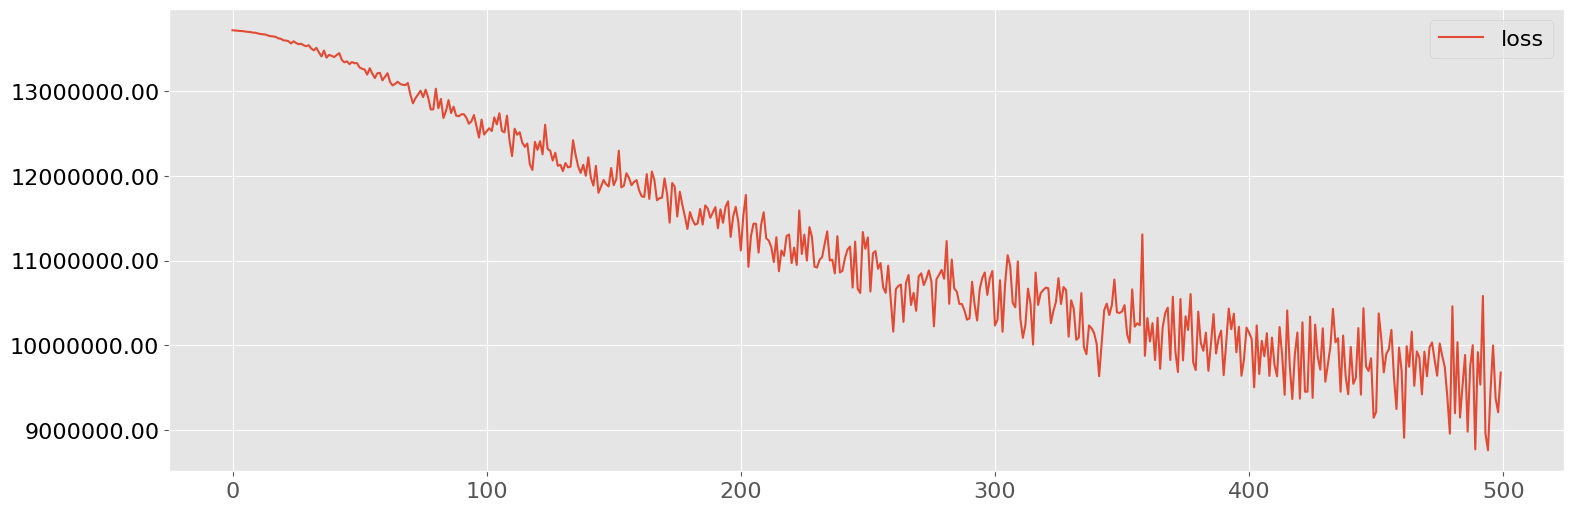

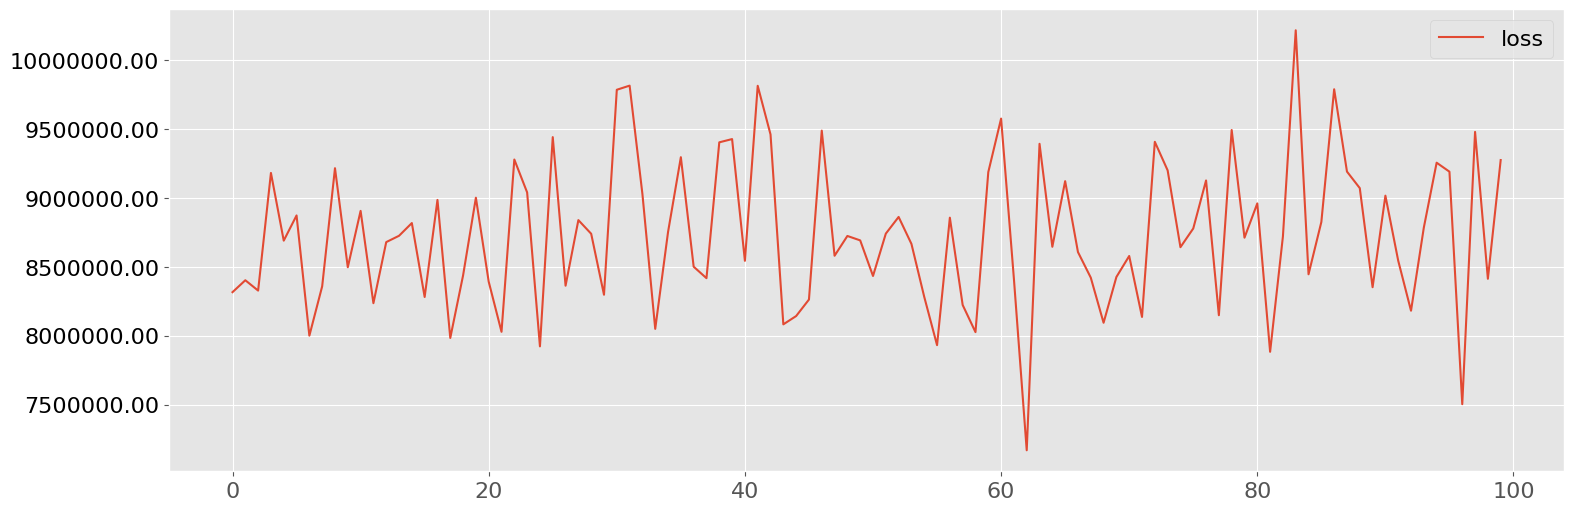

In [15]:
# plot Tenfor Flow trining 
df_loss_i = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_i.history["loss"])),  "loss":sfuvtf.history_i.history["loss"] })

bp.lineplot(df_loss_i, x ="epoch", y = "loss", figsize=(18,6), pltstyle='ggplot' )
""
df_loss_t = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_t.history["loss"])),   "loss":sfuvtf.history_t.history["loss"] })
bp.lineplot(df_loss_t, x ="epoch", y = "loss", figsize=(18,6), pltstyle='ggplot' )

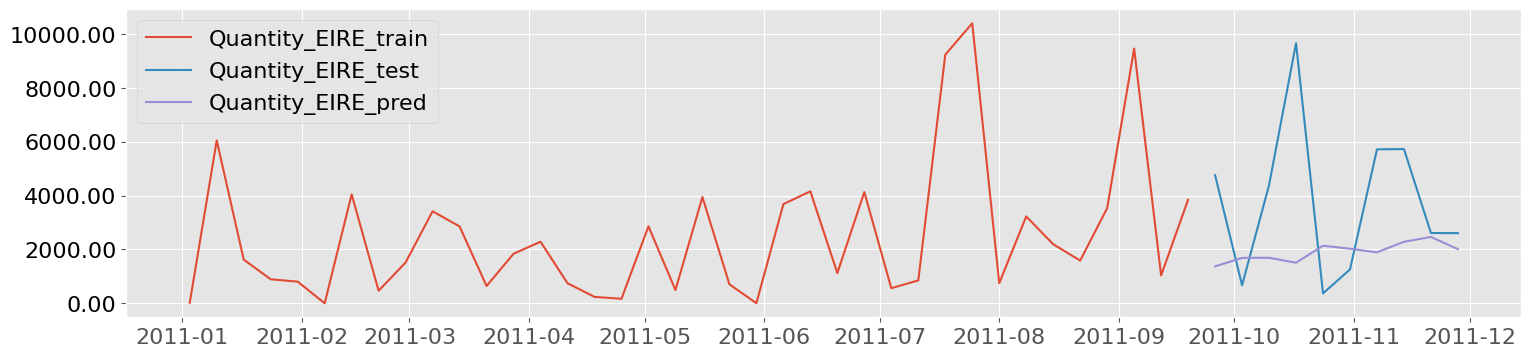

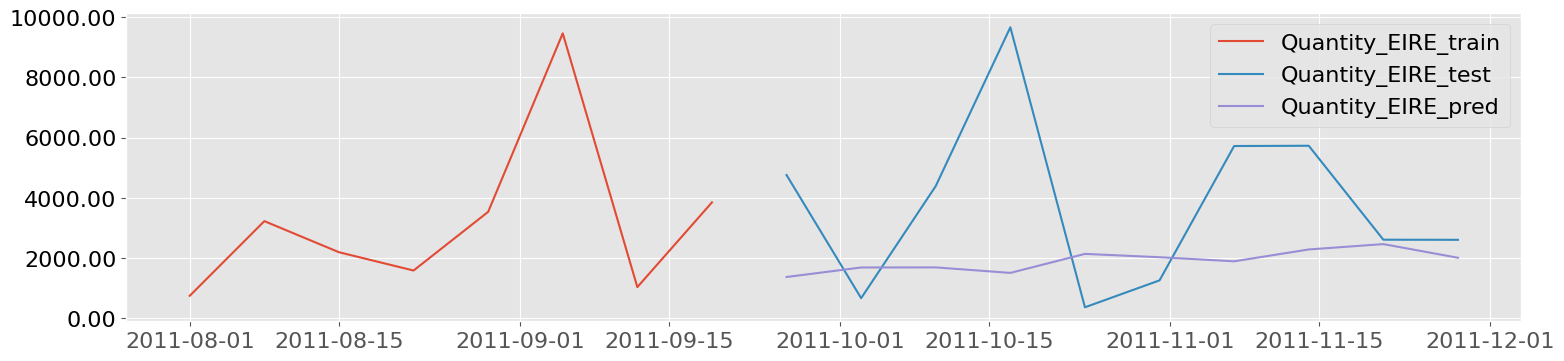

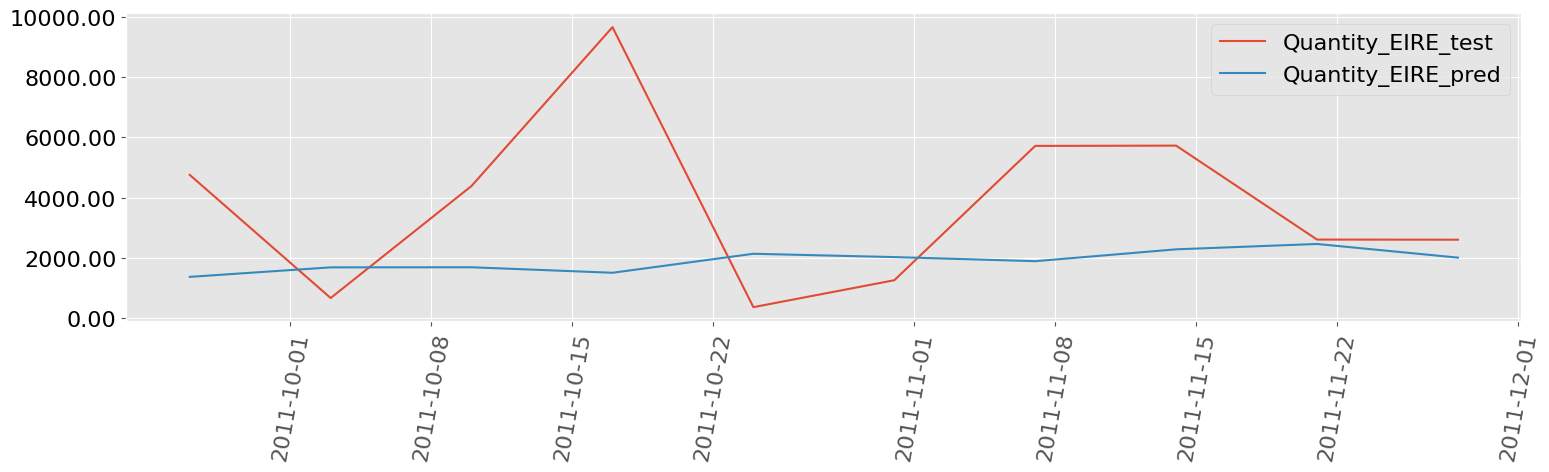

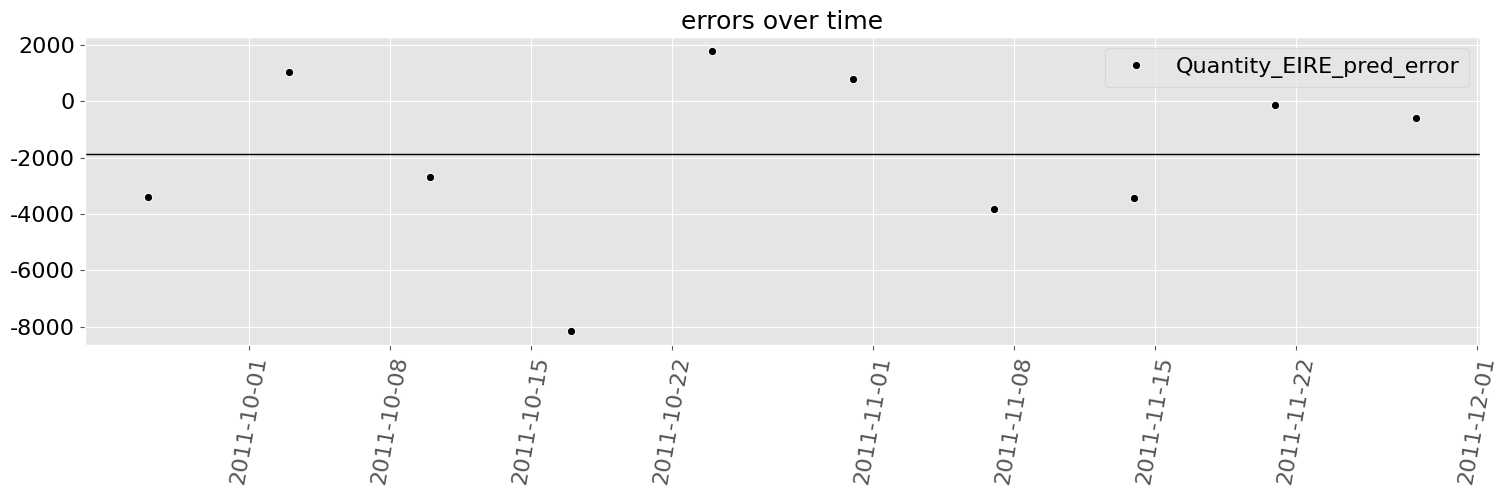

In [16]:
# Plot the Fit
y = "Quantity_EIRE"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvtf.copy().reset_index() # seaborn lineplot function needs x-axis to be a column

x = "tp"

error_avg =df[error].mean()

bp.lineplot(df, x=x , y=[ytrain, ytest , ypred], figsize=(18,4), pltstyle='ggplot')

d=datetime(2011,8,1)
bp.lineplot(df[df[x]>=d], x=x, y=[ytrain, ytest , ypred], figsize=(18,4),pltstyle='ggplot')

bp.lineplot(df.tail(30), x=x, y=[ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

bp.lineplot(df.tail(30), x=x, y=error,  h_line = [error_avg], 
            y_axis_format=".0f",linestyle="None", marker="o", color="k", 
            title = "errors over time", x_tick_rotation=80,  figsize=(18,4), pltstyle='ggplot')

Predict

In [17]:
# Predict Univariate
ts_period = pd.DateOffset(weeks=1)
#dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfuvtf.predict(Nperiods=3, ts_period=ts_period) #
df_pred

1/1 [==============================] - 0s 22ms/step


,Quantity_EIRE_pred
2011-12-05,2250.064209
2011-12-12,2315.214111
2011-12-19,2051.112305


## Multivariate

In [19]:
# multivariate data
mltx = mlprep_transforms(dfseries, datetime_column="tp", frequency=frequency)
index_col = 'tp'
covariates = ["Quantity_United Kingdom", "Quantity_Netherlands",  "Quantity_EIRE"]

cols_keep = [index_col] + covariates
dfxy = ( mltx
         .wide_format("tp", "Country", ["Quantity","SalesRevenue"])
        .filter_datetime(datetime_start=mldata_start, datetime_end=mldata_end)
        .ml_columns(columns_keep = cols_keep)
        .set_index(index_col)
        .return_df() )

dfxy.tail()

,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE
tp,,,
2011-10-31,135918.0,2657.0,1256.0
2011-11-07,149976.0,7784.0,5719.0
2011-11-14,148696.0,330.0,5728.0
2011-11-21,138686.0,7552.0,2607.0
2011-11-28,133180.0,50.0,2603.0


Neural Network

In [20]:
Nlags = 5
Ncovars = len(covariates)

tf_model_dense_mv = sf.get_dense_nn(Nlags=Nlags, Ncovars= Ncovars)

Ndense = 15
Ndense = 20.0
Nout = 3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_3 (Dense)             (None, 20)                320       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 563
Traina

MV Forecast Fit

In [22]:
y =  ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]      
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covariates,
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_mv = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_mv, tf_parameters=tf_params)

df_pred = sf_tf_dense_mv.fit(dfxy)

print(f'\nmetrics = {sf_tf_dense_mv}')
dfXY_pred_mvexen = dfxy.join(df_pred)
display(dfXY_pred_mvexen.tail())


1/1 [==============================] - 0s 23ms/step

metrics = <sforecast.sliding_forecast.sliding_forecast object at 0x1485b4bb0>


,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,Quantity_United Kingdom_train,Quantity_United Kingdom_test,Quantity_United Kingdom_pred,Quantity_United Kingdom_pred_error,Quantity_United Kingdom_pred_lower,Quantity_United Kingdom_pred_upper,Quantity_EIRE_train,Quantity_EIRE_test,Quantity_EIRE_pred,Quantity_EIRE_pred_error,Quantity_EIRE_pred_lower,Quantity_EIRE_pred_upper,Quantity_Netherlands_train,Quantity_Netherlands_test,Quantity_Netherlands_pred,Quantity_Netherlands_pred_error,Quantity_Netherlands_pred_lower,Quantity_Netherlands_pred_upper
tp,,,,,,,,,,,,,,,,,,,,,
2011-10-31,135918.0,2657.0,1256.0,135918.0,NaN,NaN,NaN,NaN,NaN,1256.0,NaN,NaN,NaN,NaN,NaN,2657.0,NaN,NaN,NaN,NaN,NaN
2011-11-07,149976.0,7784.0,5719.0,149976.0,NaN,NaN,NaN,NaN,NaN,5719.0,NaN,NaN,NaN,NaN,NaN,7784.0,NaN,NaN,NaN,NaN,NaN
2011-11-14,148696.0,330.0,5728.0,NaN,148696.0,14611.474609,-134084.525391,0.0,-98851.892969,NaN,5728.0,5982.869141,254.869141,6732.374219,9407.868750,NaN,330.0,8014.948730,7684.948730,10250.547949,15659.756934
2011-11-21,138686.0,7552.0,2607.0,NaN,138686.0,19866.857422,-118819.142578,0.0,-93596.510156,NaN,2607.0,6206.237305,3599.237305,6955.742383,9631.236914,NaN,7552.0,8475.437500,923.437500,10711.036719,16120.245703
2011-11-28,133180.0,50.0,2603.0,NaN,133180.0,21055.576172,-112124.423828,0.0,-92407.791406,NaN,2603.0,5331.048828,2728.048828,6080.553906,8756.048437,NaN,50.0,7534.246094,7484.246094,9769.845312,15179.054297


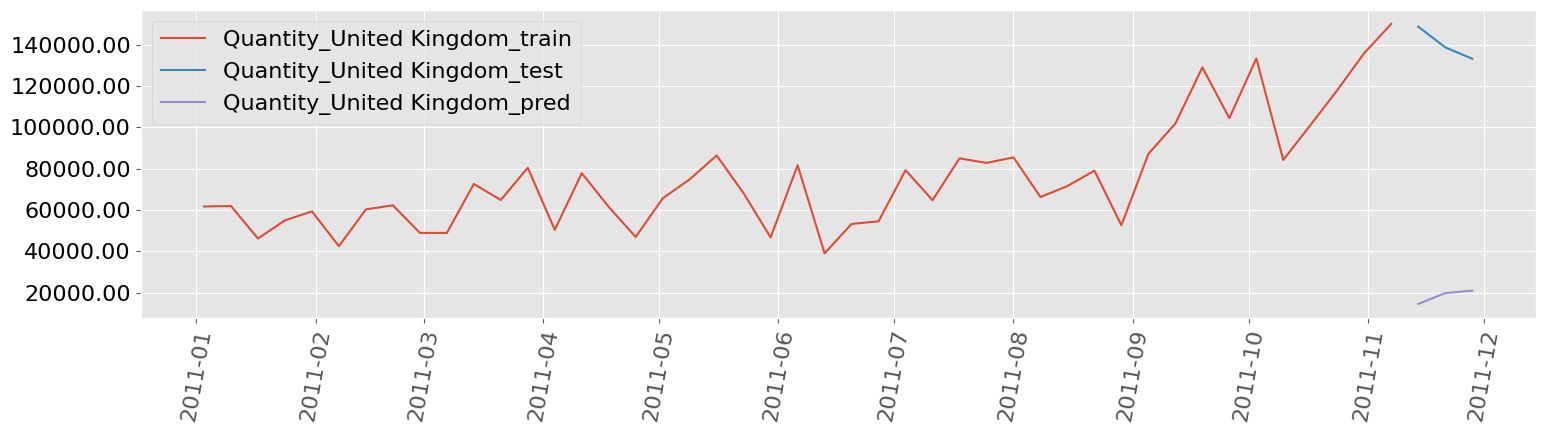

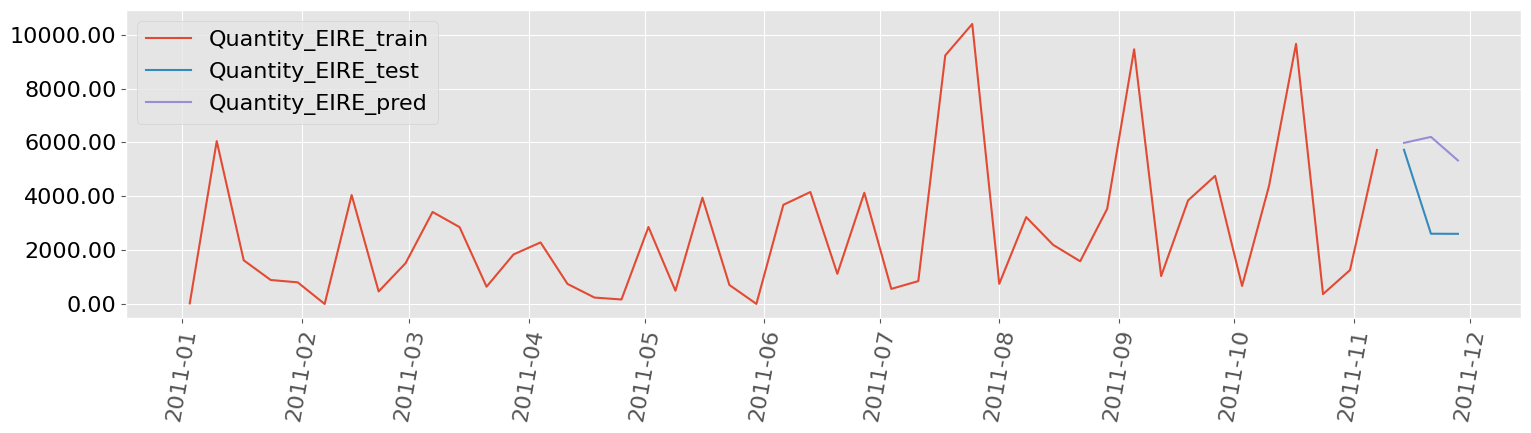

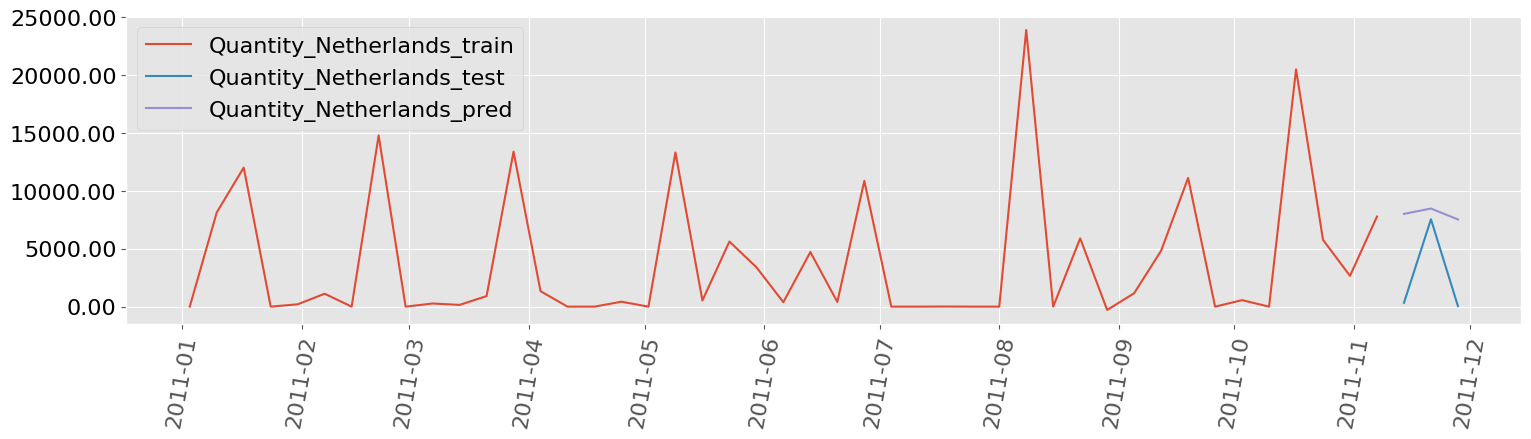

In [23]:


df = dfXY_pred_mvexen.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "Quantity_United Kingdom"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

x = 'tp'


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

y = "Quantity_EIRE"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')


y = "Quantity_Netherlands"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

In [24]:
# predict
ts_period = pd.DateOffset(weeks=1)

df_pred=sf_tf_dense_mv.predict(Nperiods=3, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 23ms/step


,Quantity_United Kingdom_pred,Quantity_EIRE_pred,Quantity_Netherlands_pred
2011-12-05,23887.177734,5112.682129,7324.755371
2011-12-12,22503.357422,4816.263672,6900.443359
2011-12-19,18872.847656,4039.172852,5787.319336


## Multivariate, Endogenous

In [25]:
# multivariate data ... same data as multivarate
mltx = mlprep_transforms(dfseries, datetime_column="tp", frequency=frequency)
index_col = 'tp'
covariates = ["Quantity_United Kingdom", "Quantity_Netherlands",  "Quantity_EIRE"]

cols_keep = [index_col] + covariates
dfxy = ( mltx
         .wide_format("tp", "Country", ["Quantity","SalesRevenue"])
        .filter_datetime(datetime_start=mldata_start, datetime_end=mldata_end)
        .ml_columns(columns_keep = cols_keep)
        .set_index(index_col)
        .return_df() )

dfxy.tail()

,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE
tp,,,
2011-10-31,135918.0,2657.0,1256.0
2011-11-07,149976.0,7784.0,5719.0
2011-11-14,148696.0,330.0,5728.0
2011-11-21,138686.0,7552.0,2607.0
2011-11-28,133180.0,50.0,2603.0


Endogenous/derived variables

In [27]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "Quantity_United Kingdom" :"mean",
    "Quantity_EIRE" : "mean",
    "Quantity_Netherlands":  "mean"
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

In [28]:
# test the transform
# -- use the teransform and
# -- observer variables will be created by sforecast


cols = ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]        
dfXY_m1 = dfxy[cols].copy()

Nclip = derived_variables_transformer.get_Nclip()
print("Nclip =",Nclip)

# -- m1 "minus 1" shift forward from the -1 position to 0th position
dfXY_m1[["Quantity_United Kingdom_m1" , "Quantity_EIRE_m1" , "Quantity_Netherlands_m1" ]] = dfXY_m1[["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]].shift(1)

dftest = derived_variables_transformer.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nrw= {Nrw} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(derived_variables_transformer.dfmemory)

new_attributes = derived_variables_transformer.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,Quantity_United Kingdom,Quantity_EIRE,Quantity_Netherlands,Quantity_United Kingdom_m1,Quantity_EIRE_m1,Quantity_Netherlands_m1,Quantity_United Kingdom_m1_mean3,Quantity_EIRE_m1_mean3,Quantity_Netherlands_m1_mean3
tp,,,,,,,,,
2011-10-31,135918.0,1256.0,2657.0,117980.0,362.0,5769.0,101077.333333,4805.000000,8754.333333
2011-11-07,149976.0,5719.0,7784.0,135918.0,1256.0,2657.0,118302.666667,3760.666667,9640.000000
2011-11-14,148696.0,5728.0,330.0,149976.0,5719.0,7784.0,134624.666667,2445.666667,5403.333333
2011-11-21,138686.0,2607.0,7552.0,148696.0,5728.0,330.0,144863.333333,4234.333333,3590.333333
2011-11-28,133180.0,2603.0,50.0,138686.0,2607.0,7552.0,145786.000000,4684.666667,5222.000000


Nrw= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,Quantity_United Kingdom,Quantity_EIRE,Quantity_Netherlands,Quantity_United Kingdom_m1,Quantity_EIRE_m1,Quantity_Netherlands_m1
tp,,,,,,
2011-11-14,148696.0,5728.0,330.0,149976.0,5719.0,7784.0
2011-11-21,138686.0,2607.0,7552.0,148696.0,5728.0,330.0
2011-11-28,133180.0,2603.0,50.0,138686.0,2607.0,7552.0



new_attribute_names = ['Quantity_United Kingdom_m1_mean3', 'Quantity_EIRE_m1_mean3', 'Quantity_Netherlands_m1_mean3']


NN Dense Endogs MV

In [29]:
Nlags = 5
Ncovars = len(covariates)
Nendogvars = 3

tf_model_dense_endogs_mv = sf.get_dense_nn(Nlags=Nlags, Ncovars= Ncovars, Nendogs = Nendogvars)

Ndense = 18
Ndense = 20.0
Nout = 3
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_6 (Dense)             (None, 20)                380       
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 623
Traina

Fit MV Endogs

In [32]:
y =  ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]      
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covariates,
    "derived_attributes_transform": derived_variables_transformer 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_exogs_mv = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endogs_mv , tf_parameters=tf_params)

df_pred = sf_tf_dense_exogs_mv.fit(dfxy)

print(f'\nmetrics = {sf_tf_dense_exogs_mv}')
dfXY_pred = dfxy.join(df_pred)
display(dfXY_pred.tail())

1/1 [==============================] - 0s 21ms/step

metrics = <sforecast.sliding_forecast.sliding_forecast object at 0x148b63910>


,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,Quantity_United Kingdom_train,Quantity_United Kingdom_test,Quantity_United Kingdom_pred,Quantity_United Kingdom_pred_error,Quantity_United Kingdom_pred_lower,Quantity_United Kingdom_pred_upper,Quantity_EIRE_train,Quantity_EIRE_test,Quantity_EIRE_pred,Quantity_EIRE_pred_error,Quantity_EIRE_pred_lower,Quantity_EIRE_pred_upper,Quantity_Netherlands_train,Quantity_Netherlands_test,Quantity_Netherlands_pred,Quantity_Netherlands_pred_error,Quantity_Netherlands_pred_lower,Quantity_Netherlands_pred_upper
tp,,,,,,,,,,,,,,,,,,,,,
2011-10-31,135918.0,2657.0,1256.0,135918.0,NaN,NaN,NaN,NaN,NaN,1256.0,NaN,NaN,NaN,NaN,NaN,2657.0,NaN,NaN,NaN,NaN,NaN
2011-11-07,149976.0,7784.0,5719.0,149976.0,NaN,NaN,NaN,NaN,NaN,5719.0,NaN,NaN,NaN,NaN,NaN,7784.0,NaN,NaN,NaN,NaN,NaN
2011-11-14,148696.0,330.0,5728.0,NaN,148696.0,13441.618164,-135254.381836,0.0,-101444.903320,NaN,5728.0,5851.465820,123.465820,6535.762109,9320.679297,NaN,330.0,7693.356934,7363.356934,9797.390039,15296.468164
2011-11-21,138686.0,7552.0,2607.0,NaN,138686.0,18134.697266,-120551.302734,0.0,-96751.824219,NaN,2607.0,6211.612305,3604.612305,6895.908594,9680.825781,NaN,7552.0,8341.202148,789.202148,10445.235254,15944.313379
2011-11-28,133180.0,50.0,2603.0,NaN,133180.0,19709.673828,-113470.326172,0.0,-95176.847656,NaN,2603.0,5530.618164,2927.618164,6214.914453,8999.831641,NaN,50.0,7713.049805,7663.049805,9817.082910,15316.161035


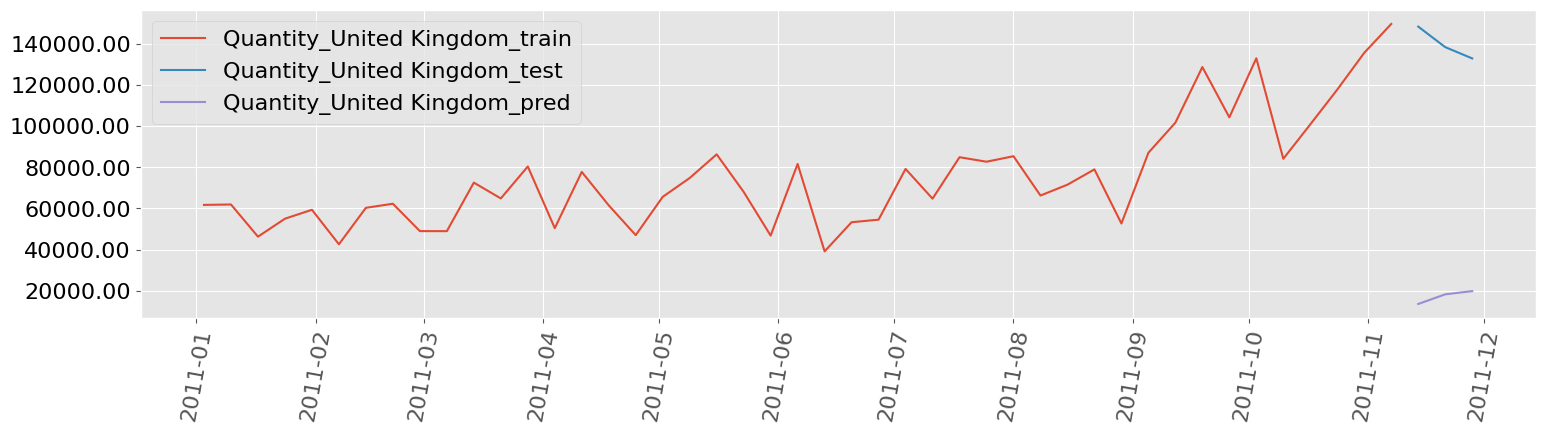

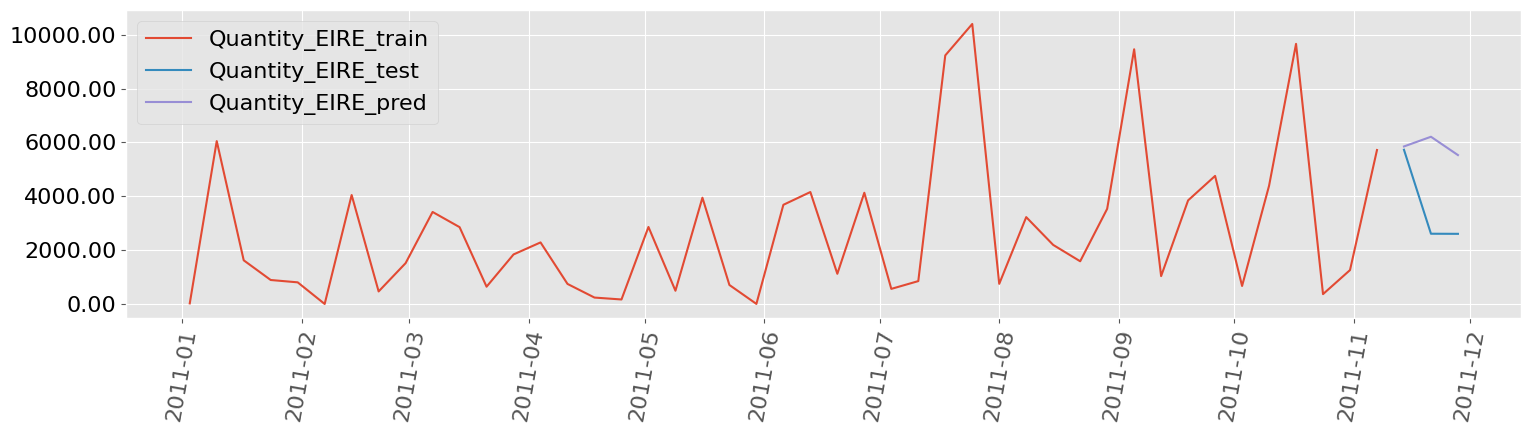

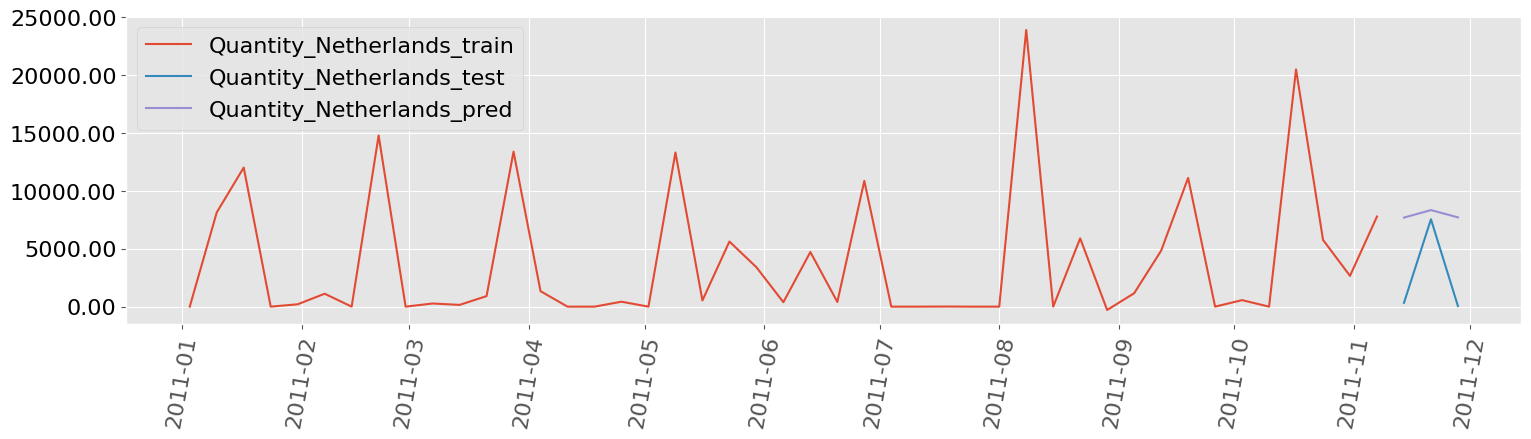

In [34]:


df = dfXY_pred.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "Quantity_United Kingdom"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

x = 'tp'


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

y = "Quantity_EIRE"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')


y = "Quantity_Netherlands"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

In [35]:
# predict
ts_period = pd.DateOffset(weeks=1)

df_pred=sf_tf_dense_exogs_mv.predict(Nperiods=3, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 23ms/step


,Quantity_United Kingdom_pred,Quantity_EIRE_pred,Quantity_Netherlands_pred
2011-12-05,21273.451172,5085.287109,7212.552246
2011-12-12,19841.324219,4742.975098,6727.348145
2011-12-19,16304.653320,3897.695557,5528.018555


## Multivariate, Endogenous, Exogenous

In [36]:
# multivariate data + Exogenous
#  -- set exogenous to year, month (not a great variable for now)
#  -- later add variables like average temperature and days of rain and amount of precipitation
mltx = mlprep_transforms(dfseries, datetime_column="tp", frequency=frequency)
index_col = 'tp'
covariates = ["Quantity_United Kingdom", "Quantity_Netherlands",  "Quantity_EIRE"]
exogvars = ["tp_Year", "tp_Month"]
cols_keep = [index_col] + covariates + exogvars

dfxy = ( mltx
         .wide_format("tp", "Country", ["Quantity","SalesRevenue"])
        .filter_datetime(datetime_start=mldata_start, datetime_end=mldata_end)
        .datepart()
        .ml_columns(columns_keep = cols_keep)
        .set_index(index_col)
        .return_df() )

dfxy.tail()

,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,tp_Year,tp_Month
tp,,,,,
2011-10-31,135918.0,2657.0,1256.0,2011,10
2011-11-07,149976.0,7784.0,5719.0,2011,11
2011-11-14,148696.0,330.0,5728.0,2011,11
2011-11-21,138686.0,7552.0,2607.0,2011,11
2011-11-28,133180.0,50.0,2603.0,2011,11


Endogenous/Derived Variables

In [37]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "Quantity_United Kingdom" :[ "mean", "std"],
    "Quantity_EIRE" : ["mean", "std"],
    "Quantity_Netherlands": [ "mean", "std" ]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

In [38]:
# test the transform
# -- use the teransform and
# -- observer variables will be created by sforecast


cols = ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]        
dfXY_m1 = dfxy[cols].copy()

Nclip = derived_variables_transformer.get_Nclip()
print("Nclip =",Nclip)

# -- m1 "minus 1" shift forward from the -1 position to 0th position
dfXY_m1[["Quantity_United Kingdom_m1" , "Quantity_EIRE_m1" , "Quantity_Netherlands_m1" ]] = dfXY_m1[["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]].shift(1)

dftest = derived_variables_transformer.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nrw= {Nrw} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(derived_variables_transformer.dfmemory)

new_attributes = derived_variables_transformer.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,Quantity_United Kingdom,Quantity_EIRE,Quantity_Netherlands,Quantity_United Kingdom_m1,Quantity_EIRE_m1,Quantity_Netherlands_m1,Quantity_United Kingdom_m1_mean3,Quantity_United Kingdom_m1_std3,Quantity_EIRE_m1_mean3,Quantity_EIRE_m1_std3,Quantity_Netherlands_m1_mean3,Quantity_Netherlands_m1_std3
tp,,,,,,,,,,,,
2011-10-31,135918.0,1256.0,2657.0,117980.0,362.0,5769.0,101077.333333,16869.100786,4805.000000,4664.932261,8754.333333,10568.120473
2011-11-07,149976.0,5719.0,7784.0,135918.0,1256.0,2657.0,118302.666667,17456.236746,3760.666667,5131.940893,9640.000000,9527.755402
2011-11-14,148696.0,5728.0,330.0,149976.0,5719.0,7784.0,134624.666667,16037.161137,2445.666667,2869.815732,5403.333333,2582.985934
2011-11-21,138686.0,2607.0,7552.0,148696.0,5728.0,330.0,144863.333333,7773.277387,4234.333333,2579.316253,3590.333333,3813.641610
2011-11-28,133180.0,2603.0,50.0,138686.0,2607.0,7552.0,145786.000000,6181.998059,4684.666667,1799.317741,5222.000000,4238.184045


Nrw= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,Quantity_United Kingdom,Quantity_EIRE,Quantity_Netherlands,Quantity_United Kingdom_m1,Quantity_EIRE_m1,Quantity_Netherlands_m1
tp,,,,,,
2011-11-14,148696.0,5728.0,330.0,149976.0,5719.0,7784.0
2011-11-21,138686.0,2607.0,7552.0,148696.0,5728.0,330.0
2011-11-28,133180.0,2603.0,50.0,138686.0,2607.0,7552.0



new_attribute_names = ['Quantity_United Kingdom_m1_mean3', 'Quantity_United Kingdom_m1_std3', 'Quantity_EIRE_m1_mean3', 'Quantity_EIRE_m1_std3', 'Quantity_Netherlands_m1_mean3', 'Quantity_Netherlands_m1_std3']


NN Endog Exog MV

In [40]:
Nlags = 5
Ncovars = len(covariates)
Nexogs = len(exogvars)
Nendogvars=6

tf_model_dense_endog_exog_mv = sf.get_dense_nn(Nlags=Nlags, Ncovars= Ncovars, Nendogs = Nendogvars, Nexogs = Nexogs)

Ndense = 23
Ndense = 23.0
Nout = 3
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_9 (Dense)             (None, 23)                552       
                                                                 
 dropout_6 (Dropout)         (None, 23)                0         
                                                                 
 dense_10 (Dense)            (None, 12)                288       
                                                                 
 dropout_7 (Dropout)         (None, 12)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 39        
                                                                 
Total params: 879
Traina

NN Fit

In [42]:
y =  ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]      
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covariates,
    "exogvars":exogvars,
    "derived_attributes_transform": derived_variables_transformer
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_endog_exog_mv = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_mv , tf_parameters=tf_params)

df_pred = sf_tf_dense_endog_exog_mv.fit(dfxy)

print(f'\nmetrics = {sf_tf_dense_endog_exog_mv.metrics}')
dfXY_pred_endog_exog_mv = dfxy.join(df_pred)
display(dfXY_pred_endog_exog_mv.tail())

1/1 [==============================] - 0s 20ms/step

metrics = {'Quantity_United Kingdom_pred': {'RMSE': 125751.96056938764, 'MAE': 125461.13118489583}, 'Quantity_EIRE_pred': {'RMSE': 2040.4505795909386, 'MAE': 1822.5263671875}, 'Quantity_Netherlands_pred': {'RMSE': 5645.972478144312, 'MAE': 4620.657063802083}}


,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,tp_Year,tp_Month,Quantity_United Kingdom_train,Quantity_United Kingdom_test,Quantity_United Kingdom_pred,Quantity_United Kingdom_pred_error,Quantity_United Kingdom_pred_lower,Quantity_United Kingdom_pred_upper,Quantity_EIRE_train,Quantity_EIRE_test,Quantity_EIRE_pred,Quantity_EIRE_pred_error,Quantity_EIRE_pred_lower,Quantity_EIRE_pred_upper,Quantity_Netherlands_train,Quantity_Netherlands_test,Quantity_Netherlands_pred,Quantity_Netherlands_pred_error,Quantity_Netherlands_pred_lower,Quantity_Netherlands_pred_upper
tp,,,,,,,,,,,,,,,,,,,,,,,
2011-10-31,135918.0,2657.0,1256.0,2011,10,135918.0,NaN,NaN,NaN,NaN,NaN,1256.0,NaN,NaN,NaN,NaN,NaN,2657.0,NaN,NaN,NaN,NaN,NaN
2011-11-07,149976.0,7784.0,5719.0,2011,11,149976.0,NaN,NaN,NaN,NaN,NaN,5719.0,NaN,NaN,NaN,NaN,NaN,7784.0,NaN,NaN,NaN,NaN,NaN
2011-11-14,148696.0,330.0,5728.0,2011,11,NaN,148696.0,11829.291992,-136866.708008,0.0,-105848.440039,NaN,5728.0,5165.914551,-562.085449,5153.421094,7778.784766,NaN,330.0,7208.401855,6878.401855,8558.092773,14144.948242
2011-11-21,138686.0,7552.0,2607.0,2011,11,NaN,138686.0,15459.972656,-123226.027344,0.0,-102217.759375,NaN,2607.0,5326.619141,2719.619141,5314.125684,7939.489355,NaN,7552.0,7519.513184,-32.486816,8869.204102,14456.059570
2011-11-28,133180.0,50.0,2603.0,2011,11,NaN,133180.0,16889.341797,-116290.658203,0.0,-100788.390234,NaN,2603.0,4788.874512,2185.874512,4776.381055,7401.744727,NaN,50.0,7001.082520,6951.082520,8350.773438,13937.628906


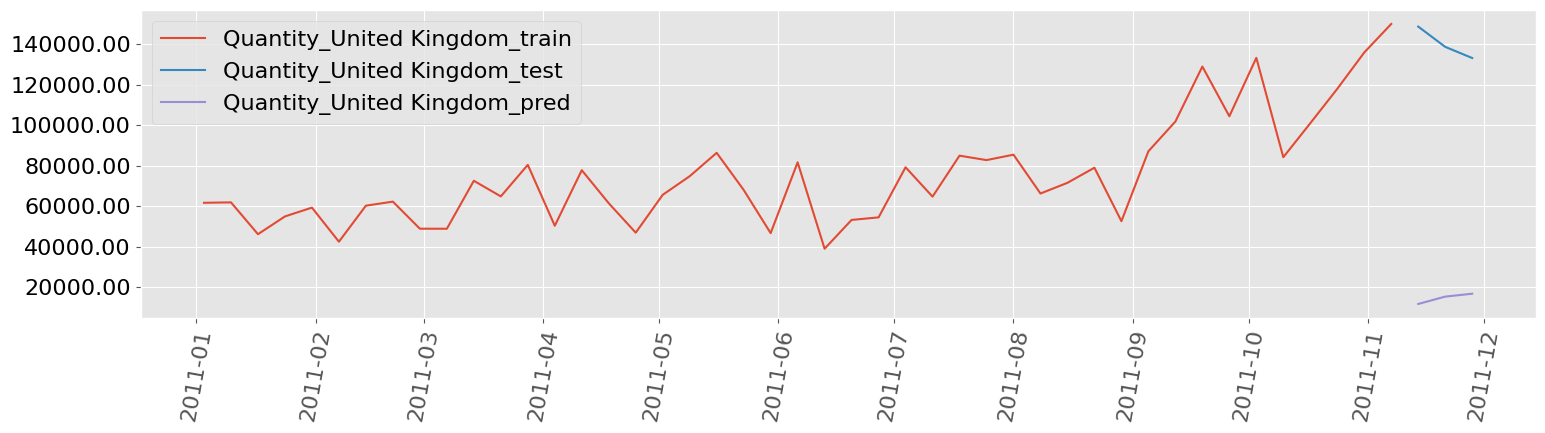

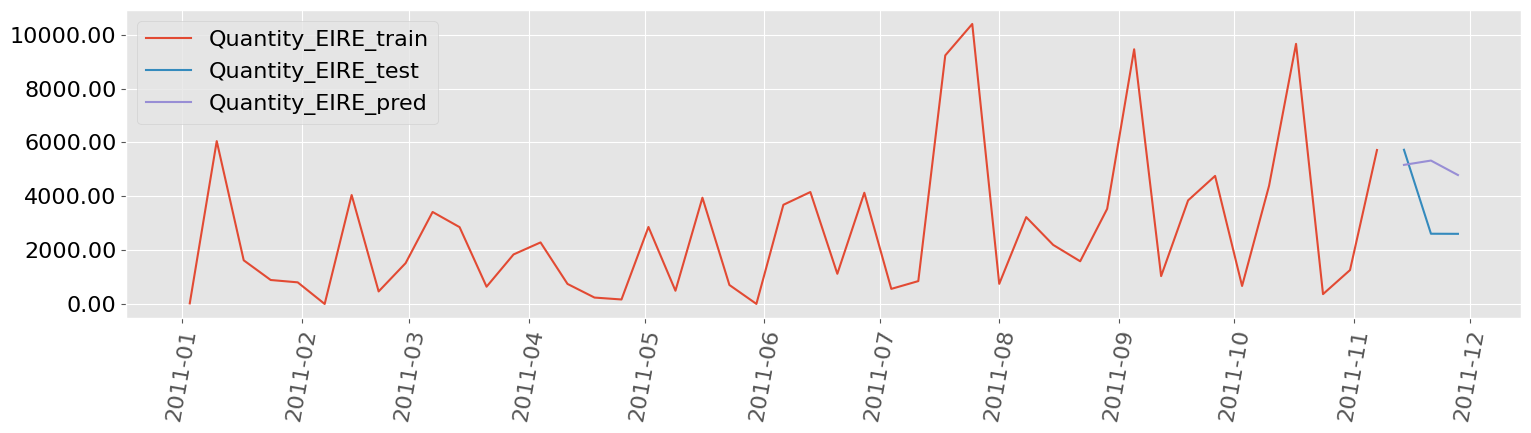

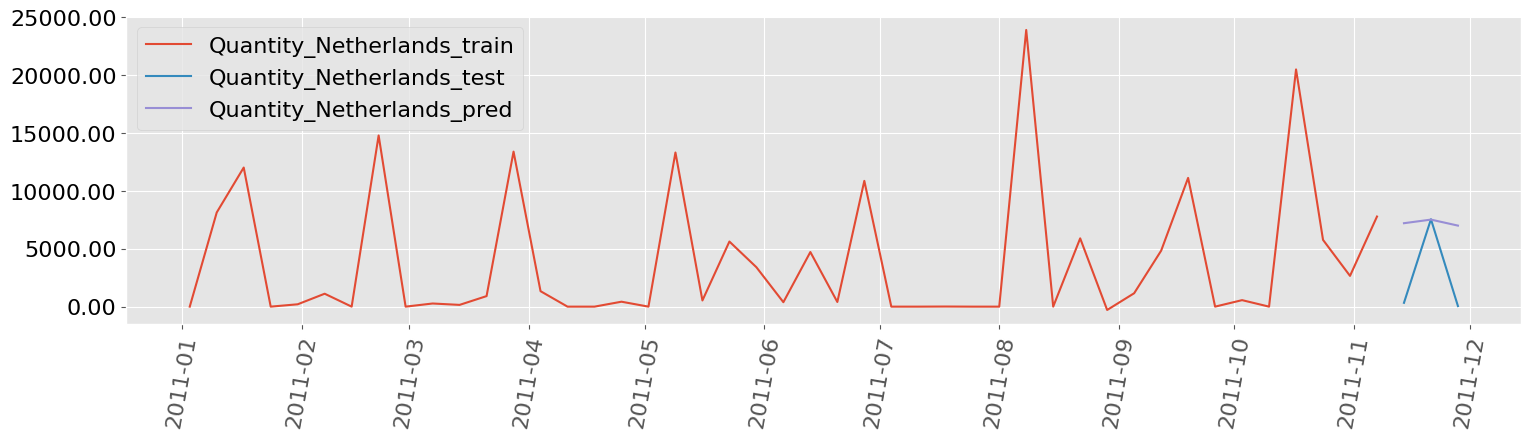

In [43]:
# Plot Multivariate + Exogenous

df = dfXY_pred_endog_exog_mv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "Quantity_United Kingdom"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

x = 'tp'

bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

y = "Quantity_EIRE"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

y = "Quantity_Netherlands"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

In [44]:
# predict
ts_period = pd.DateOffset(weeks=1)
df_exogs = pd.DataFrame(
    {"tp_Year": [2011, 2012, 2012],
     "tp_Month": [12, 1, 2]
    })

df_pred=sf_tf_dense_endog_exog_mv.predict(Nperiods=3,dfexogs = df_exogs, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 21ms/step


,Quantity_United Kingdom_pred,Quantity_EIRE_pred,Quantity_Netherlands_pred
2011-12-05,18637.724609,4512.066406,6696.823242
2011-12-12,19034.765625,4607.740723,6838.688477
2011-12-19,16554.007812,4007.417969,5947.315430


## Multivariate, Exogenous, Endogenous, Categorical

In [45]:
# multivariate data + Endogenous + Exogenous + Categorical
#  -- set exogenous to year, month (not a great variable for now)
#  -- later add variables like average temperature and days of rain and amount of precipitation
mltx = mlprep_transforms(dfseries, datetime_column="tp", frequency=frequency)
index_col = 'tp'
covariates = ["Quantity_United Kingdom", "Quantity_Netherlands",  "Quantity_EIRE"]
exogvars = ["tp_Year", "tp_Month"]
catvars = ["tp_Quarter", "tp_Is_month_start", "tp_Is_month_end", "tp_Is_quarter_start", "tp_Is_quarter_end", "tp_Is_year_start", "tp_Is_year_end" ]
catvars = ["tp_Quarter", "tp_Is_month_start"]
cols_keep = [index_col] + covariates + exogvars + catvars

dfxy = ( mltx
         .wide_format("tp", "Country", ["Quantity","SalesRevenue"])
        .filter_datetime(datetime_start=mldata_start, datetime_end=mldata_end)
        .datepart()
        .ml_columns(columns_keep = cols_keep)
        .set_index(index_col)
        .return_df() )

dfxy.tail()

,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,tp_Year,tp_Month,tp_Quarter,tp_Is_month_start
tp,,,,,,,
2011-10-31,135918.0,2657.0,1256.0,2011,10,4,0.0
2011-11-07,149976.0,7784.0,5719.0,2011,11,4,1.0
2011-11-14,148696.0,330.0,5728.0,2011,11,4,0.0
2011-11-21,138686.0,7552.0,2607.0,2011,11,4,0.0
2011-11-28,133180.0,50.0,2603.0,2011,11,4,0.0


Endogenous/Derived Variables

In [47]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "Quantity_United Kingdom" :[ "mean", "std"],
    "Quantity_EIRE" : ["mean", "std"],
    "Quantity_Netherlands": [ "mean", "std" ]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

NN Endog Exog Categorical MV

In [48]:
Nlags = 5
Ncovars = len(covariates)
Nexogs = len(exogvars)
Nendogvars=6

tf_model_dense_endog_exog_emb_mv = sf.get_dense_emb_nn(dfxy, Nlags,catvars, Ncovars= Ncovars, Nendogs = Nendogvars, Nexogs = Nexogs)

Ndense = 23
Nemb = 2
Nout = 3
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 23), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_7')>]
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           

In [49]:
catvars

['tp_Quarter', 'tp_Is_month_start']

In [50]:
y =  ["Quantity_United Kingdom" , "Quantity_EIRE" , "Quantity_Netherlands"]      
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covariates,
    "exogvars":exogvars,
    "catvars":catvars,
    "derived_attributes_transform": derived_variables_transformer 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_endog_exog_emb_mv = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_emb_mv, tf_parameters=tf_params)

df_pred = sf_tf_dense_endog_exog_emb_mv.fit(dfxy)

print(f'\nmetrics = {sf_tf_dense_endog_exog_emb_mv.metrics}')
dfXY_pred_endog_exog_emb_mv = dfxy.join(df_pred)
display(dfXY_pred_endog_exog_emb_mv.tail())

1/1 [==============================] - 0s 26ms/step

metrics = {'Quantity_United Kingdom_pred': {'RMSE': 19013.57096761766, 'MAE': 17554.760416666668}, 'Quantity_EIRE_pred': {'RMSE': 1636.8210662344673, 'MAE': 1617.6640625}, 'Quantity_Netherlands_pred': {'RMSE': 4658.309259915046, 'MAE': 4300.149088541667}}


,Quantity_United Kingdom,Quantity_Netherlands,Quantity_EIRE,tp_Year,tp_Month,tp_Quarter,tp_Is_month_start,Quantity_United Kingdom_train,Quantity_United Kingdom_test,Quantity_United Kingdom_pred,Quantity_United Kingdom_pred_error,Quantity_United Kingdom_pred_lower,Quantity_United Kingdom_pred_upper,Quantity_EIRE_train,Quantity_EIRE_test,Quantity_EIRE_pred,Quantity_EIRE_pred_error,Quantity_EIRE_pred_lower,Quantity_EIRE_pred_upper,Quantity_Netherlands_train,Quantity_Netherlands_test,Quantity_Netherlands_pred,Quantity_Netherlands_pred_error,Quantity_Netherlands_pred_lower,Quantity_Netherlands_pred_upper
tp,,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-31,135918.0,2657.0,1256.0,2011,10,4,0.0,135918.0,NaN,NaN,NaN,NaN,NaN,1256.0,NaN,NaN,NaN,NaN,NaN,2657.0,NaN,NaN,NaN,NaN,NaN
2011-11-07,149976.0,7784.0,5719.0,2011,11,4,1.0,149976.0,NaN,NaN,NaN,NaN,NaN,5719.0,NaN,NaN,NaN,NaN,NaN,7784.0,NaN,NaN,NaN,NaN,NaN
2011-11-14,148696.0,330.0,5728.0,2011,11,4,0.0,NaN,148696.0,121292.570312,-27403.429688,96304.401563,110280.164062,NaN,5728.0,4368.705078,-1359.294922,3588.947949,6240.626465,NaN,330.0,6027.012207,5697.012207,5696.125000,11670.994141
2011-11-21,138686.0,7552.0,2607.0,2011,11,4,0.0,NaN,138686.0,128752.273438,-9933.726562,103764.104688,117739.867188,NaN,2607.0,4562.303223,1955.303223,3782.546094,6434.224609,NaN,7552.0,5780.425781,-1771.574219,5449.538574,11424.407715
2011-11-28,133180.0,50.0,2603.0,2011,11,4,0.0,NaN,133180.0,117852.875000,-15327.125000,92864.706250,106840.468750,NaN,2603.0,4141.394043,1538.394043,3361.636914,6013.315430,NaN,50.0,5481.860840,5431.860840,5150.973633,11125.842773


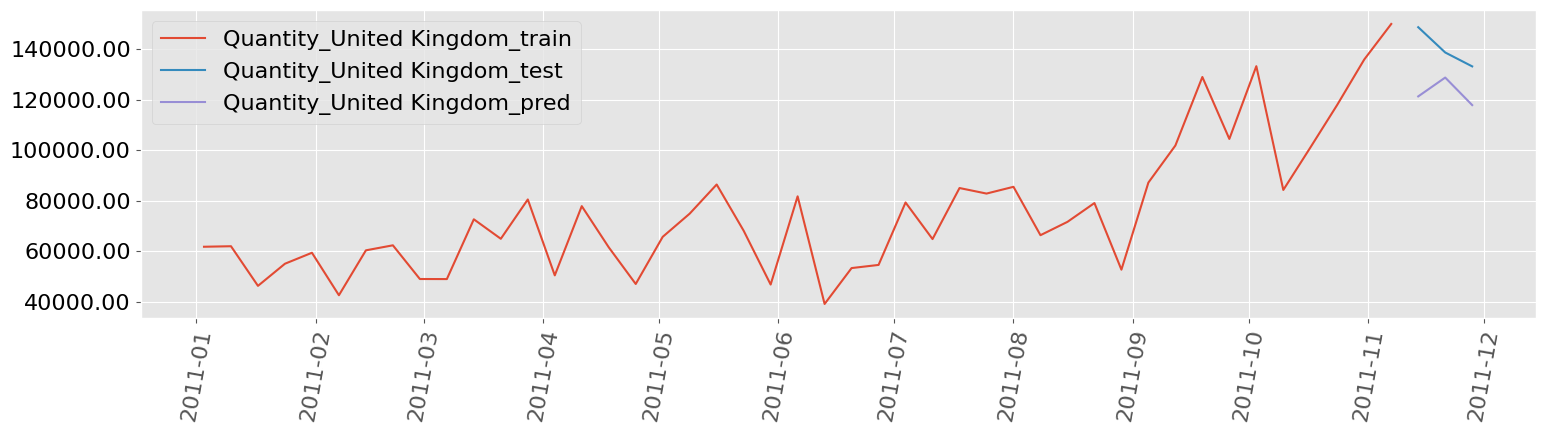

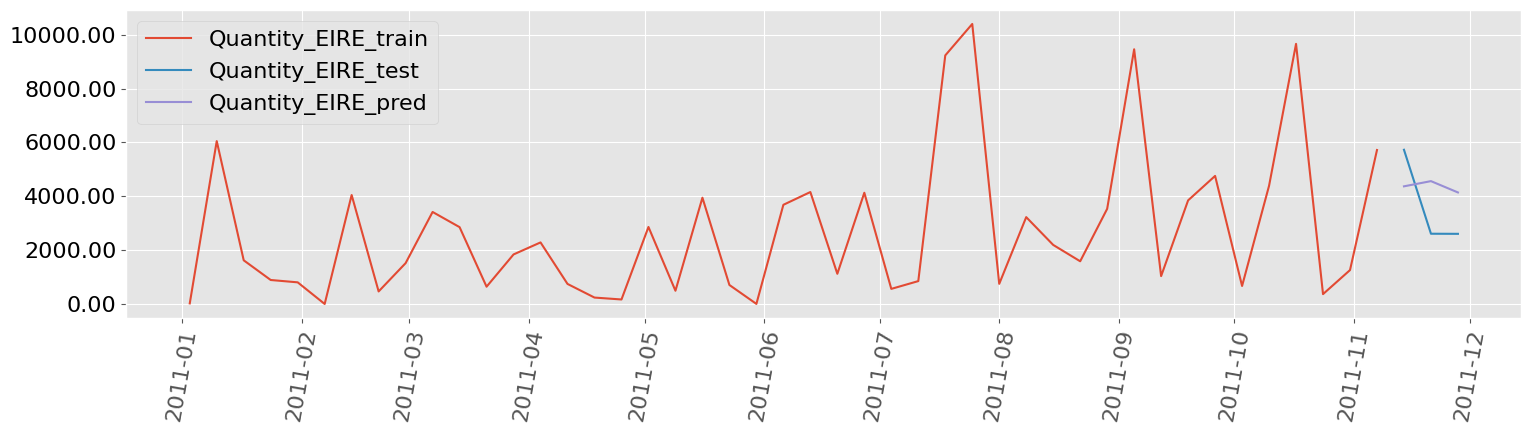

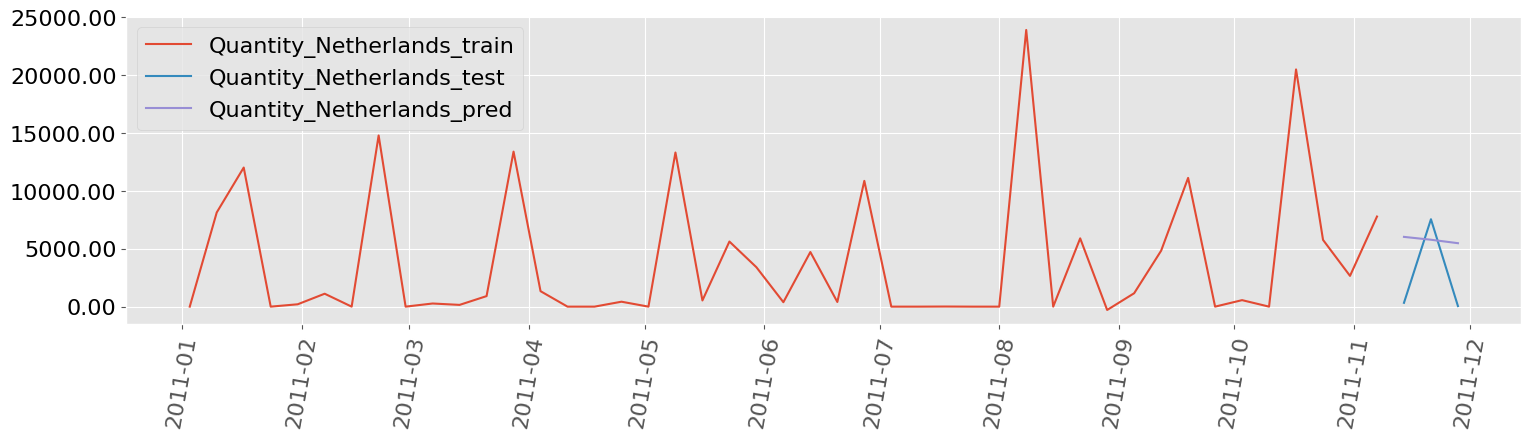

In [51]:
# Plut Multivariate + Exogenous

df = dfXY_pred_endog_exog_emb_mv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "Quantity_United Kingdom"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

x = 'tp'

bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

y = "Quantity_EIRE"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')


y = "Quantity_Netherlands"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x=x, y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80, pltstyle='ggplot')

In [52]:
# predict
ts_period = pd.DateOffset(weeks=1)
df_exogs = pd.DataFrame(
    {"tp_Year": [2011, 2012, 2012],
     "tp_Month": [12, 1, 2]
    })

dfcats = pd.DataFrame({"tp_Quarter": [0, 1, 0], "tp_Is_month_start": [1, 0, 0]})
df_pred=sf_tf_dense_endog_exog_emb_mv.predict(Nperiods=3,dfexogs = df_exogs,dfcats=dfcats, ts_period=ts_period)

df_pred

1/1 [==============================] - 0s 26ms/step


,Quantity_United Kingdom_pred,Quantity_EIRE_pred,Quantity_Netherlands_pred
2011-12-05,118914.656250,4017.635986,5239.978027
2011-12-12,105676.351562,3570.581543,4656.879395
2011-12-19,98193.281250,3317.631348,4326.986816
